# Ensemble Learning

Ensemble learning methods aim to achieve better generalization performance compared to a single model by combining several machine learning models as a meta-model.

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
iris = datasets.load_iris()
x, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, stratify=y, random_state=1)

The goal of ensemble learning methods is to achieve better predictive performance than an individual model by connecting several classifiers (or regressors) together. The majority voting (plurality voting for multi-classification problem) is a method that simply selecting a class label that acquires the majority of prediction. 

$\hat{y} = argmax\sum_{j=1}^m w_j p_{ij}$ where $p_{ij}$ is the probability of $j$-th model on class label $i$.

In [2]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import six
import operator
# Majority voting ensemble classifier
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    '''
    classifiers: a list of classifier models.
    vote: either {'label', 'probability'}.
          If 'label', return an index of class label that has the majority of prediction.
          If 'probability', return an index of class label that has the higher probability summation.
    weights: a list of weights to use. Default value is 'None'.
             If a list of integers or floats is given, the classifier utilizes it as an importance weights.
             Argument 'None' means the weights are all equal.
    '''
    def __init__(self, classifiers, vote='label', weights=None):
        self.classifiers = classifiers
        self.vote = vote
        self.weights = weights
        self.named_classifiers = {k: v for k, v in _name_estimators(classifiers)}
    
    def fit(self, x, y):
        if self.vote not in {'label', 'probability'}:
            raise ValueError("'%r' is not either 'label' or 'probability'." % self.vote)
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError("The number of classifers and weights should be identical.")
        self.le_ = LabelEncoder()
        self.le_.fit_transform(y)
        self.classes_ = self.le_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fit_clf = clone(clf).fit(x, y)
            self.classifiers_.append(fit_clf)
        return self
        
    def predict(self, x):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(x), axis=1) 
        else:
            # self.vote == 'label'
            predictions = np.asarray([clf.predict(x) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
        maj_vote = self.le_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, x):
        probabilities = np.asarray([clf.predict_proba(x) for clf in self.classifiers_])
        avg_proba = np.average(probabilities, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [3]:
# Before ensemble learning, compare three different classifiers' (LR, DT, K-Neighbor) predictive performance.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
lr = LogisticRegression(C=0.001, random_state=1)
dt = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=1)
knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
lr_pipe = Pipeline([['sc', StandardScaler()], ['lr', lr]])
knn_pipe = Pipeline([['sc', StandardScaler()], ['knn', knn]])
clfs = [lr_pipe, dt, knn_pipe]
clf_labels = ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbors']
for clf, label in zip(clfs, clf_labels):
    scores = cross_val_score(estimator=clf, X=x_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic Regression]
ROC AUC: 0.87 (+/- 0.18) [Decision Tree]
ROC AUC: 0.85 (+/- 0.13) [K-Nearest Neighbors]


Use `MajorityVoteClassifier()` to put together all three classifiers defined above and compare their performances.

In [4]:
mv = MajorityVoteClassifier(classifiers=clfs)
clf_labels += ['Majority Voting']
clfs = [lr_pipe, dt, knn_pipe, mv]
for clf, label in zip(clfs, clf_labels):
    scores = cross_val_score(estimator=clf, X=x_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic Regression]
ROC AUC: 0.87 (+/- 0.18) [Decision Tree]
ROC AUC: 0.85 (+/- 0.13) [K-Nearest Neighbors]
ROC AUC: 0.98 (+/- 0.05) [Majority Voting]


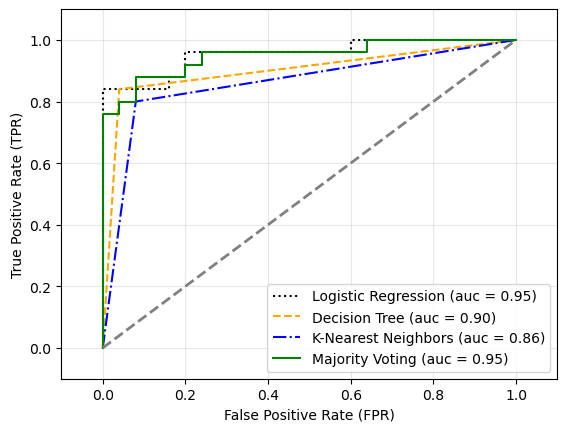

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, color, ls in zip(clfs, clf_labels, colors, linestyles):
    y_pred = clf.fit(x_train, y_train).predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, linestyle=ls, label='%s (auc = %.2f)' % (label, roc_auc))
plt.legend(loc='best')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.3)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

# VotingClassifier

Instead of building a self-implemented `MajorVotingClassifier()`, use scikit-learn's built-in ensemble learning API called `VotingClassifer()`.

In [6]:
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier(estimators=[('lr', lr_pipe), ('dt', dt), ('knn', knn_pipe)], voting='soft')
scores = cross_val_score(estimator=vc, X=x_train, y=y_train, cv=10, scoring='roc_auc')
print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'VotingClassifier'))

ROC AUC: 0.98 (+/- 0.05) [VotingClassifier]


After all, let's look at the decision boundaries of all classifiers.

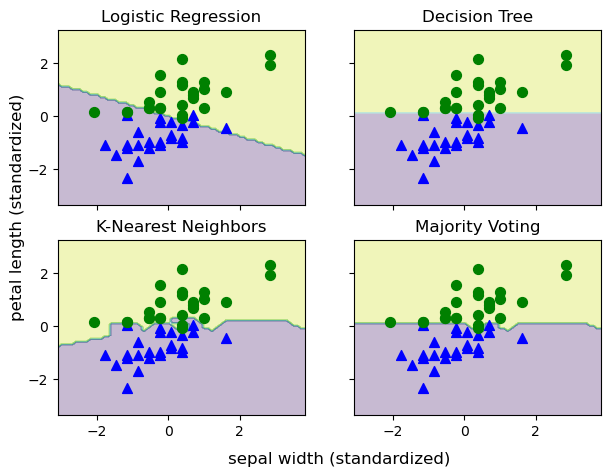

In [7]:
from itertools import product
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x1_min, x1_max = x_train_std[:, 0].min(), x_train_std[:, 0].max()
x2_min, x2_max = x_train_std[:, 1].min(), x_train_std[:, 1].max()
x1_coordinates, x2_coordinates = np.meshgrid(
    np.arange(x1_min - 1, x1_max + 1, 0.1),
    np.arange(x2_min - 1, x2_max + 1, 0.1)
)
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))
for idx, clf, title in zip(product([0, 1], [0, 1]), clfs, clf_labels):
    clf.fit(x_train_std, y_train)
    Z = clf.predict(np.column_stack([x1_coordinates.ravel(), x2_coordinates.ravel()]))
    Z = Z.reshape(x1_coordinates.shape)
    axarr[idx[0], idx[1]].contourf(x1_coordinates, x2_coordinates, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(x_train_std[y_train == 0, 0], x_train_std[y_train == 0, 1], c='blue', marker='^', s=50)
    axarr[idx[0], idx[1]].scatter(x_train_std[y_train == 1, 0], x_train_std[y_train == 1, 1], c='green', marker='o', s=50)
    axarr[idx[0], idx[1]].set_title(title)
plt.text(-3.5, -5, s='sepal width (standardized)', ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, s='petal length (standardized)', ha='center', va='center', fontsize=12, rotation=90)
plt.show()

In [8]:
mv.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['lr', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['knn', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['lr', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__lr': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__lr__C': 0.001,
 'pipeline-1__lr__class_weight': None,
 'pipeline-1__lr__dual': False,
 'pipeline-1__lr__fit_intercept': True,
 'pipeline-1__lr__intercept_scaling': 1,
 'pipeline-1__lr__l1_ratio': None,
 'pipeline-1__lr__max_iter': 100,
 'pipeline-1__lr__multi_class'

# Bagging

Bagging, one of the ensemble learning methods, uses bootstrap samples (random samples with replacement) instead of the entire training dataset to train all the classifiers in an ensemble. Then, it aggregates each individual predictions by utilizing majority voting to output the final decision. For more details about a bagging classifier, visit scikit-learn.org about [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html).

In [9]:
import pandas as pd
wine_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
wine_df.columns = ['label', 'alcohol', 'malic acid', 'ash', 'alcalinity of ash', 'magnesium', 'total phenols',
                  'flavanoids', 'nonflavanoid phenols', 'proanthocyanins', 'color intensity', 'hue',
                   '0D280/0D315 of diluted wines', 'proline']
# use label 2 and 3, feature 'alcohol' and '0D280/0D315 of diluted wines'.
wine_df = wine_df[wine_df['label'] != 1]
x = wine_df[['alcohol', '0D280/0D315 of diluted wines']].to_numpy()
y = wine_df['label'].to_numpy()
le = LabelEncoder()
y = le.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1)

In [10]:
clf_labels = ['Decision Tree', 'Bagging']
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=None)
bag = BaggingClassifier(estimator=tree, n_estimators=500, random_state=1, n_jobs=-1)
tree.fit(x_train, y_train)
bag.fit(x_train, y_train)
for clf, label in zip([tree, bag], clf_labels):
    print('[%s] train accuracy: %.3f / test accuarcy: %.3f' % (label, clf.score(x_train, y_train), clf.score(x_test, y_test)))

[Decision Tree] train accuracy: 1.000 / test accuarcy: 0.833
[Bagging] train accuracy: 1.000 / test accuarcy: 0.917


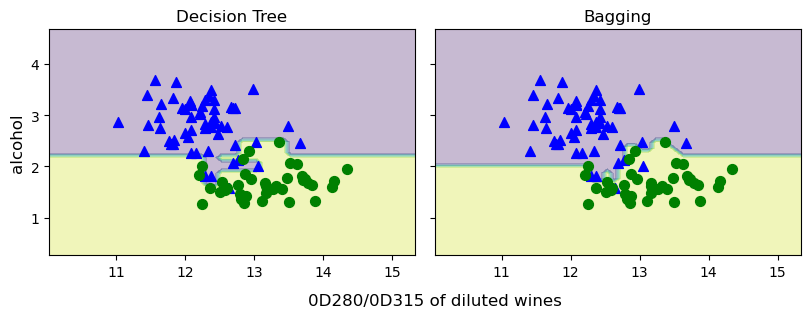

In [11]:
x1_min, x1_max = x_train[:, 0].min(), x_train[:, 0].max()
x2_min, x2_max = x_train[:, 1].min(), x_train[:, 1].max()
x1_coordinates, x2_coordinates = np.meshgrid(
    np.arange(x1_min - 1, x1_max + 1, 0.1),
    np.arange(x2_min - 1, x2_max + 1, 0.1)
)
f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8, 3))
for idx, clf, title in zip([0, 1], [tree, bag], clf_labels):
    clf.fit(x_train, y_train)
    Z = clf.predict(np.column_stack([x1_coordinates.ravel(), x2_coordinates.ravel()]))
    Z = Z.reshape(x1_coordinates.shape)
    axarr[idx].contourf(x1_coordinates, x2_coordinates, Z, alpha=0.3)
    axarr[idx].scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], c='blue', marker='^', s=50)
    axarr[idx].scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], c='green', marker='o', s=50)
    axarr[idx].set_title(title)
plt.tight_layout()
axarr[0].set_ylabel('alcohol', fontsize=12)
plt.text(0, -0.2, s='0D280/0D315 of diluted wines', ha='center', va='center', fontsize=12, transform=axarr[1].transAxes)
plt.show()

# Adaboost

Adaboost, short name for Adaptive Boosting, is one of the boosting methods that comprises a set of weak learners as an ensemble. One of the typical examples of weak learner is a decision tree of depth 1. The main idea of boosting is to focus on the samples that are difficult to distinguish the label. The incorrectly classified samples from the preceded weak learner are trained again by subsequent classifiers with high adjusted weights, or decrease in weights for samples that are predicted correctly. Increase in weights means classifiers are more concentrated on the samples that they have missed previously. As a result, the boosting method helps to improve the performance and produce a powerful ensemble.

["The main difference between bagging and boosting is the way in which they are trained. Bagging method trains classifiers in parallel, but classifiers in boosting learn sequentially."](https://www.ibm.com/cloud/learn/boosting) For more information about the boosting, visit [IBM Cloud article "What is Boosting?"](https://www.ibm.com/cloud/learn/boosting).

In [12]:
clf_labels = ['Decision Tree', 'Adaboost']
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1)
ada = AdaBoostClassifier(estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)
tree.fit(x_train, y_train)
ada.fit(x_train, y_train)
for clf, label in zip([tree, ada], clf_labels):
    print('[%s] train accuracy: %.3f / test accuarcy: %.3f' % (label, clf.score(x_train, y_train), clf.score(x_test, y_test)))

[Decision Tree] train accuracy: 0.916 / test accuarcy: 0.875
[Adaboost] train accuracy: 1.000 / test accuarcy: 0.917


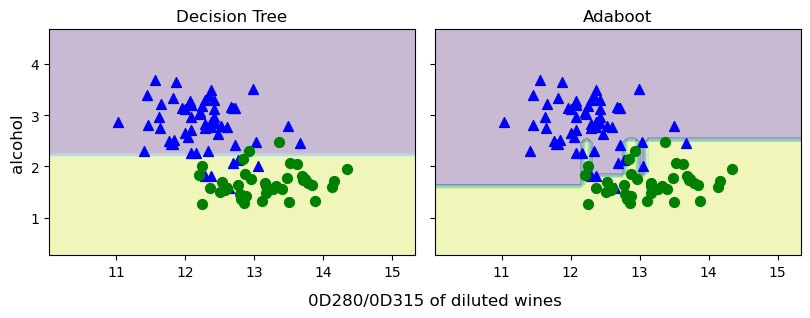

In [13]:
x1_min, x1_max = x_train[:, 0].min(), x_train[:, 0].max()
x2_min, x2_max = x_train[:, 1].min(), x_train[:, 1].max()
x1_coordinates, x2_coordinates = np.meshgrid(
    np.arange(x1_min - 1, x1_max + 1, 0.1),
    np.arange(x2_min - 1, x2_max + 1, 0.1)
)
f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8, 3))
for idx, clf, title in zip([0, 1], [tree, ada], ['Decision Tree', 'Adaboot']):
    clf.fit(x_train, y_train)
    Z = clf.predict(np.column_stack([x1_coordinates.ravel(), x2_coordinates.ravel()]))
    Z = Z.reshape(x1_coordinates.shape)
    axarr[idx].contourf(x1_coordinates, x2_coordinates, Z, alpha=0.3)
    axarr[idx].scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], c='blue', marker='^', s=50)
    axarr[idx].scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], c='green', marker='o', s=50)
    axarr[idx].set_title(title)
plt.tight_layout()
axarr[0].set_ylabel('alcohol', fontsize=12)
plt.text(0, -0.2, s='0D280/0D315 of diluted wines', ha='center', va='center', fontsize=12, transform=axarr[1].transAxes)
plt.show()

If you want to learn more about different ensemble learning methods not discussed in this guide, visit scikit-learn.org about [Ensemble Methods](https://scikit-learn.org/stable/modules/ensemble.html).